In [1]:
from pathlib import Path as pt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sigfig
import json
import uncertainties as uc
import numpy as np

In [2]:
base_loc1 = pt(r'/Users/aravindhnivas/Documents/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/')
base_loc2 = pt(r'/Users/aravindhnivas/Documents/ML-properties/[CRITICAL CONSTANTS OF ORGANIC COMPOUNDS]/')

processed_data_dirs = [
    base_loc1 / 'tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data',
    base_loc1 / 'tbp_C_processed_data/analysis_data/filtered/tbp_topelements_processed_data',
    base_loc1 / 'vp_kPa_25C_filtered_ydata_processed_data/analysis_data/filtered/vp_kPa_25C_topelements_processed_data',
    base_loc2 / 'Pc_MPa_processed_data',
    base_loc2 / 'Tc_K_processed_data'
]

plots_dir = pt('/Users/aravindhnivas/Documents/ML-properties/plots/')

# titles = [
#     'MP (C)', 'BP (C)', 'VP (kPa @25C)', 'P$_c$ (MPa)', 'T$_c$ (K)'
# ]
titles = ['MP', 'BP', 'VP', 'CP', 'CT']
total_counts = [7476, 4915, 398, 777, 819]

In [6]:
metadata = {}
for dirs in processed_data_dirs:
    metadata[dirs.name] = {}
    embedded_vectors_dir = dirs / 'embedded_vectors'
    # embeddings = 'mol2vec_embeddings'
    for embeddings in ['mol2vec_embeddings', 'VICGAE_embeddings']:
        metadata[dirs.name][embeddings] = {}
        metadata_file = embedded_vectors_dir / f'processed_{embeddings}' / 'metadata.json'
        with open(metadata_file, 'r') as f:
            metadata[dirs.name][embeddings] = json.load(f)

print(json.dumps(metadata, indent=4))

{
    "tmpC_topelements_processed_data": {
        "mol2vec_embeddings": {
            "original_X_shape": 7476,
            "validated_X_shape": 7476,
            "original_y_index": 7476,
            "final_y_index": 7476,
            "final_X_shape": 7476,
            "cleaned_X_shape": 5980,
            "cleaned_y_shape": 5980
        },
        "VICGAE_embeddings": {
            "original_X_shape": 7476,
            "validated_X_shape": 7200,
            "original_y_index": 7476,
            "final_y_index": 7200,
            "final_X_shape": 7200,
            "cleaned_X_shape": 5940,
            "cleaned_y_shape": 5940
        }
    },
    "tbp_topelements_processed_data": {
        "mol2vec_embeddings": {
            "original_X_shape": 4915,
            "validated_X_shape": 4915,
            "original_y_index": 4915,
            "final_y_index": 4915,
            "final_X_shape": 4915,
            "cleaned_X_shape": 4865,
            "cleaned_y_shape": 4865
        },
        "

In [3]:
data_dir = processed_data_dirs[0]
df = pd.read_csv(data_dir / "analysis_data/molecule_analysis_results.csv")
df.columns

Index(['INDEX', 'SMILES', 'MolecularWeight', 'No. of atoms', 'IsAromatic',
       'IsNonCyclic', 'IsCyclicNonAromatic', 'Category', 'Elements',
       'ElementCategories', 'total_rings', 'aromatic_rings', 'aliphatic_rings',
       'saturated_rings', 'heterocycles'],
      dtype='object')

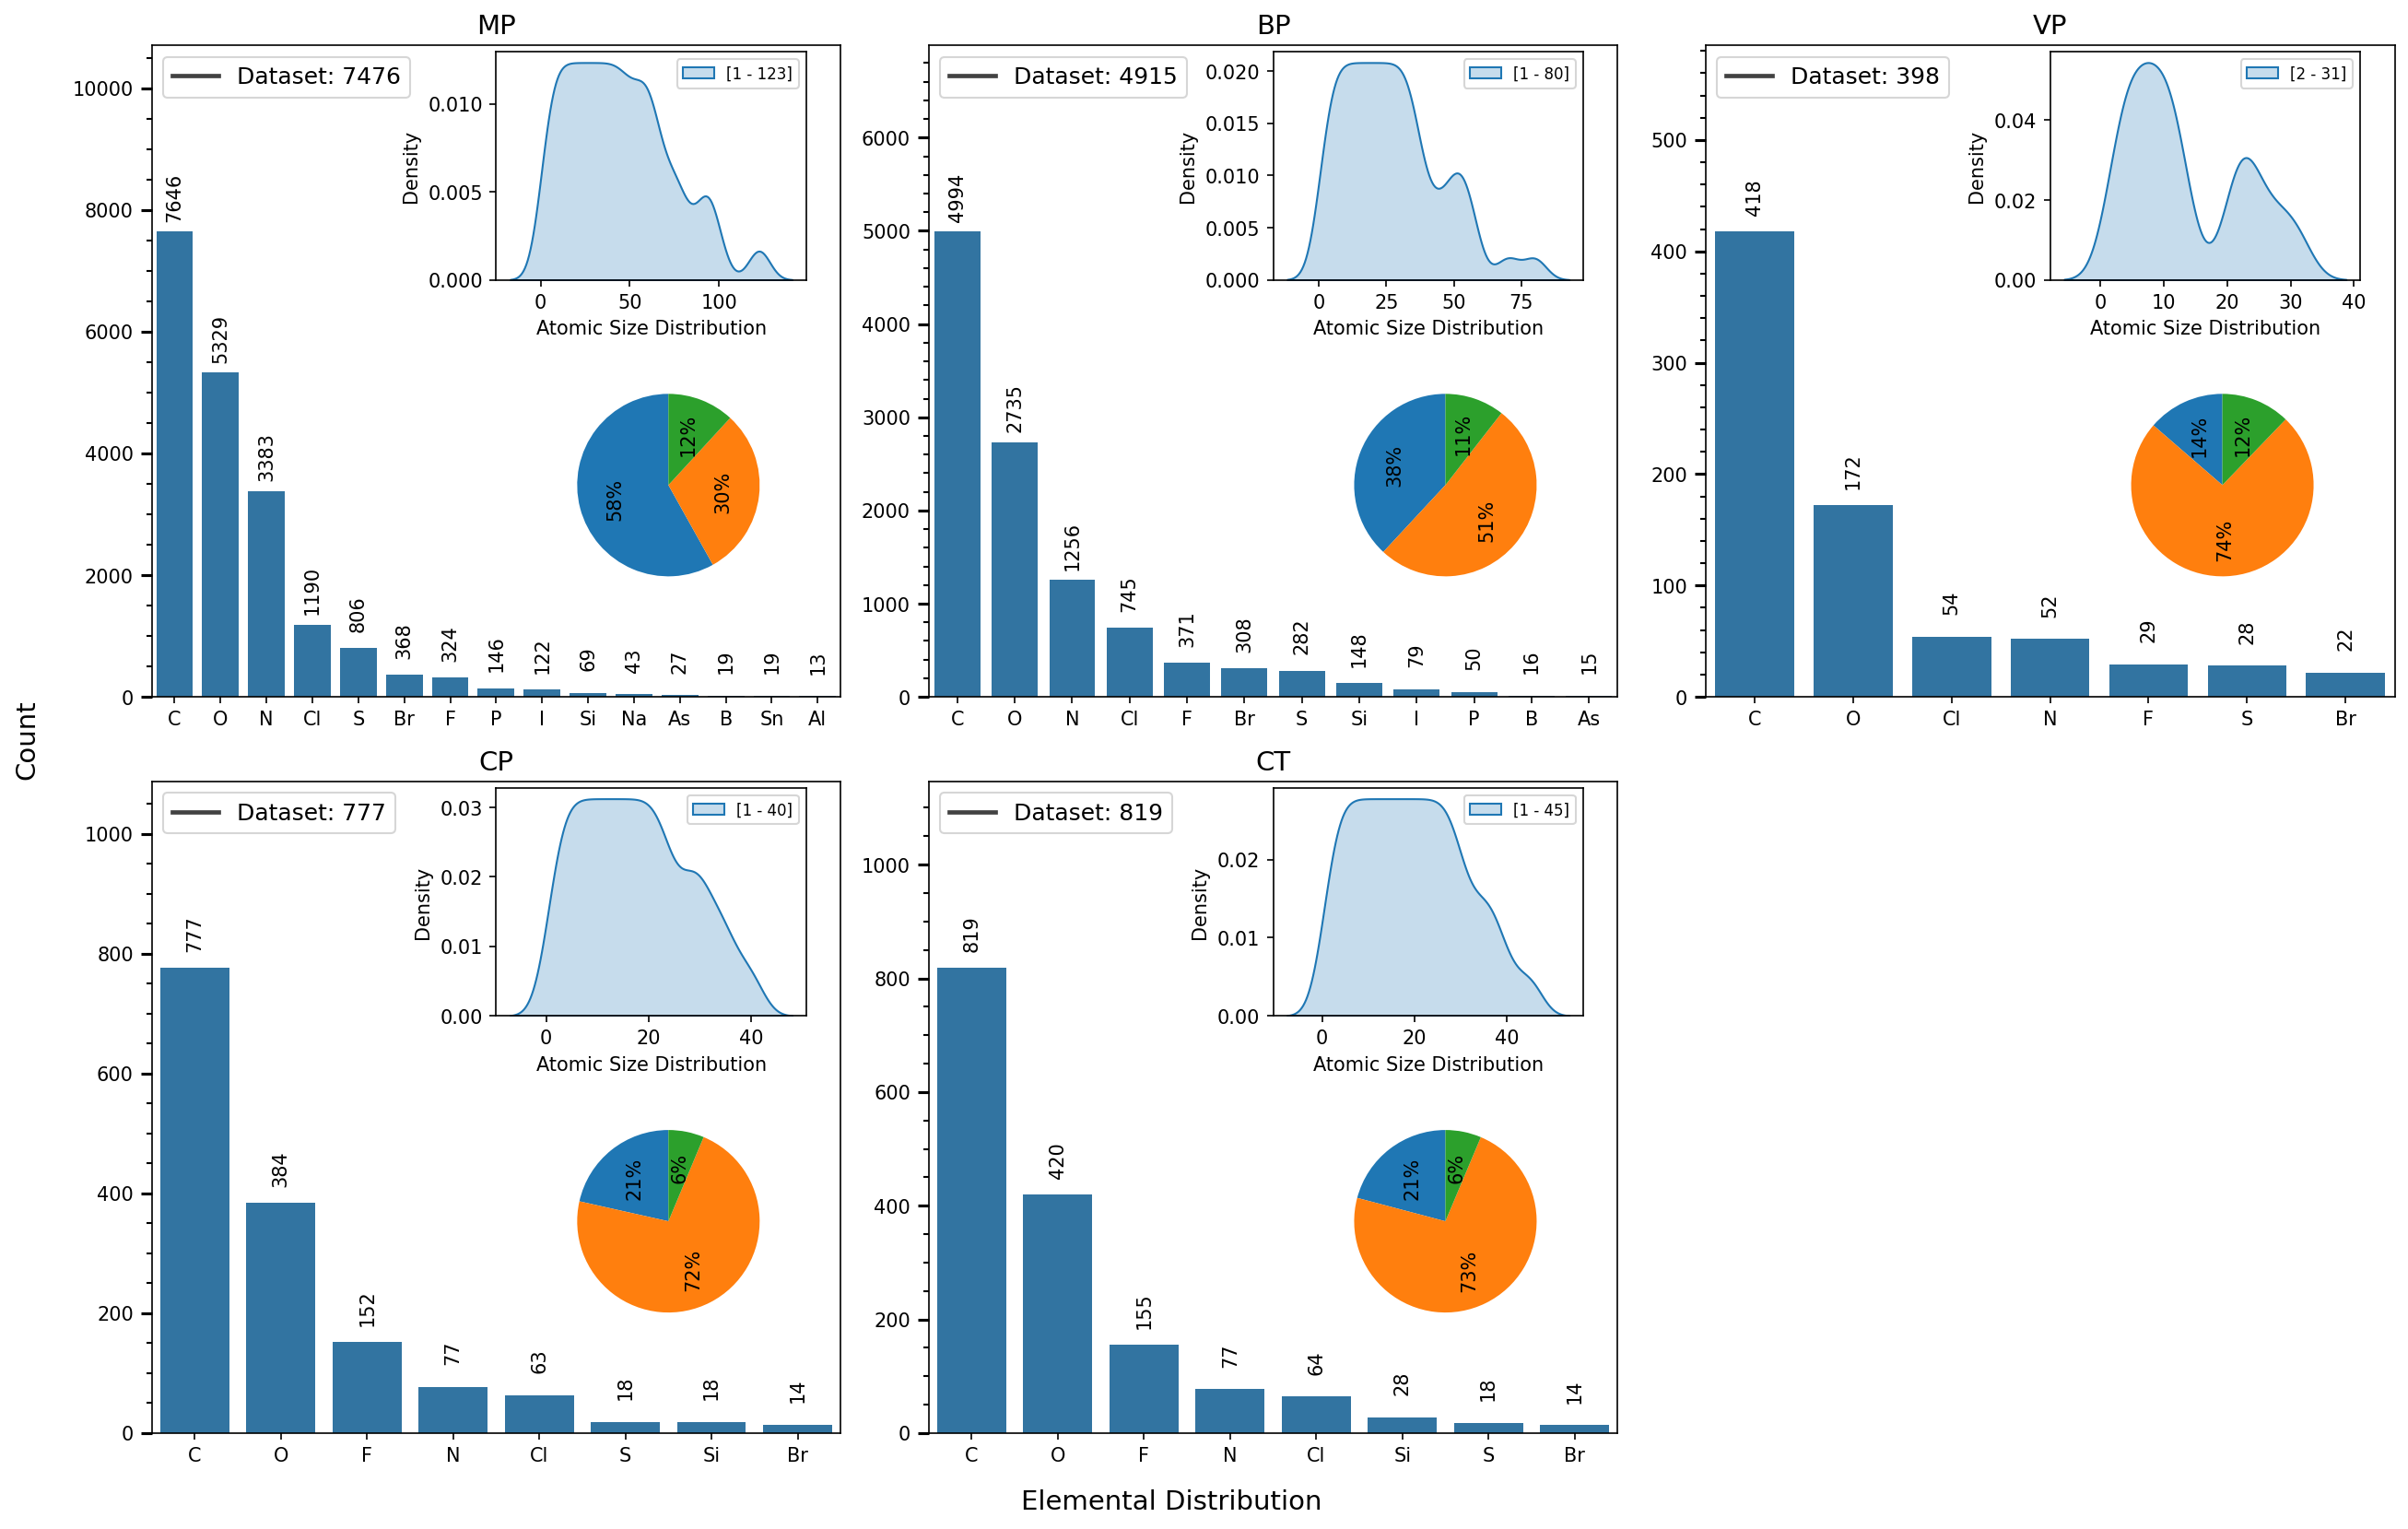

In [117]:
%matplotlib inline
# Create a 3x3 grid of subplots
plt.close('all')
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    ax = axes[i]
    analysis_file = data_dir / 'analysis_data/elemental_distribution.csv'
    df_elemental_distribution = pd.read_csv(analysis_file)
    
    # remove counts < 10
    df_elemental_distribution = df_elemental_distribution[df_elemental_distribution['Count'] >= 10]
    
    sns.barplot(data=df_elemental_distribution, x='Element', y='Count', ax=ax, legend=False)
    ax.set_xlabel('')  # Remove individual X labels
    ax.set_ylabel('')  # Remove individual Y labels
    
    _title = f'Dataset: {total_counts[i]}'
    # ax.set_title(f'{titles[i]} ({_title})', fontsize=14)  # Set individual titles
    ax.set_title(titles[i], fontsize=14)  # Set individual titles
    ax.legend([_title], loc='upper left', fontsize=12)
    
    # Add count numbers on top of each bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            rotation='vertical',
            xytext=(0, 18),  # 9 points vertical offset
            textcoords='offset points'
        )
    
    # increase y-axis limits by 10% to avoid cutting off the top of the bars
    ax.set_ylim(0, 1.4 * df_elemental_distribution['Count'].max())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', width=1.5, length=6, which='major')
    ax.tick_params(axis='y', width=1, length=3, which='minor')
    
    # inset the atomic size distribution plot
    atomic_size_distribution_file = data_dir / 'analysis_data/size_distribution.csv'
    df_atomic_size_distribution = pd.read_csv(atomic_size_distribution_file)
    # df_atomic_size_distribution - columns: 'No. of atoms', 'Count'
    
    # Create inset axes
    # [x0, y0, width, height]
    inset_ax = ax.inset_axes([0.5, 0.64, 0.45, 0.35])  # Adjust the position and size as needed
    sns.kdeplot(df_atomic_size_distribution['No. of atoms'], ax=inset_ax, bw_adjust=0.5, fill=True)
    inset_ax.set_xlabel('Atomic Size Distribution', fontsize=10)
    atomic_size_min = df_atomic_size_distribution['No. of atoms'].min()
    atomic_size_max = df_atomic_size_distribution['No. of atoms'].max()
    range_text = f'[{atomic_size_min} - {atomic_size_max}]'
    inset_ax.legend([range_text], loc='upper right', fontsize=8)
    
    inset_ax2 = ax.inset_axes([0.5, 0.15, 0.5, 0.35])
    df_structural_distribution = pd.read_csv(data_dir / 'analysis_data/structural_distribution.csv')
    # print(df_structural_distribution.head())
    inset_ax2.pie(
        df_structural_distribution['Count'], 
        autopct='%.0f%%', 
        startangle=90,
    )
    
    for text in inset_ax2.texts:
        text.set_rotation(text.get_rotation() + 90)
    
    
# Remove the last subplot (bottom-right) if it exists
if len(processed_data_dirs) < 6:
    fig.delaxes(axes[-1])
    
# Add common X and Y labels
fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.savefig(plots_dir / 'elemental_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

<Axes: xlabel='Processed tmp/ºC', ylabel='Count'>

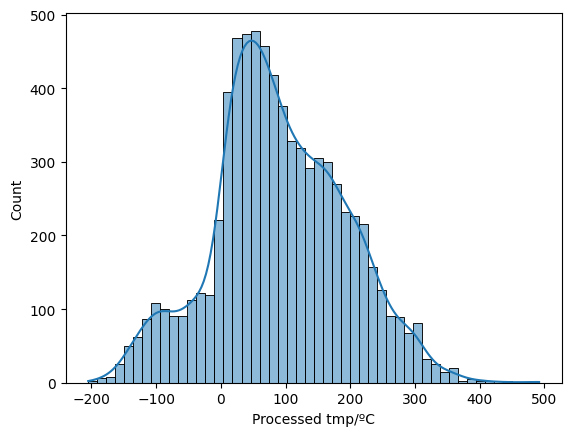

In [11]:
csv_file = list(processed_data_dirs[0].parent.glob('*.csv'))[0]
df = pd.read_csv(csv_file)
y = df['Processed tmp/ºC']
y.shape, csv_file.name
sns.histplot(y, bins=50, kde=True)

tmpC_topelements_processed_data (7476,) tmpC_topelements.csv
tbp_topelements_processed_data (4915,) tbp_topelements.csv
vp_kPa_25C_topelements_processed_data (398,) vp_kPa_25C_topelements.csv
Pc_MPa_processed_data (777,) Pc_MPa.csv
Tc_K_processed_data (819,) Tc_K.csv


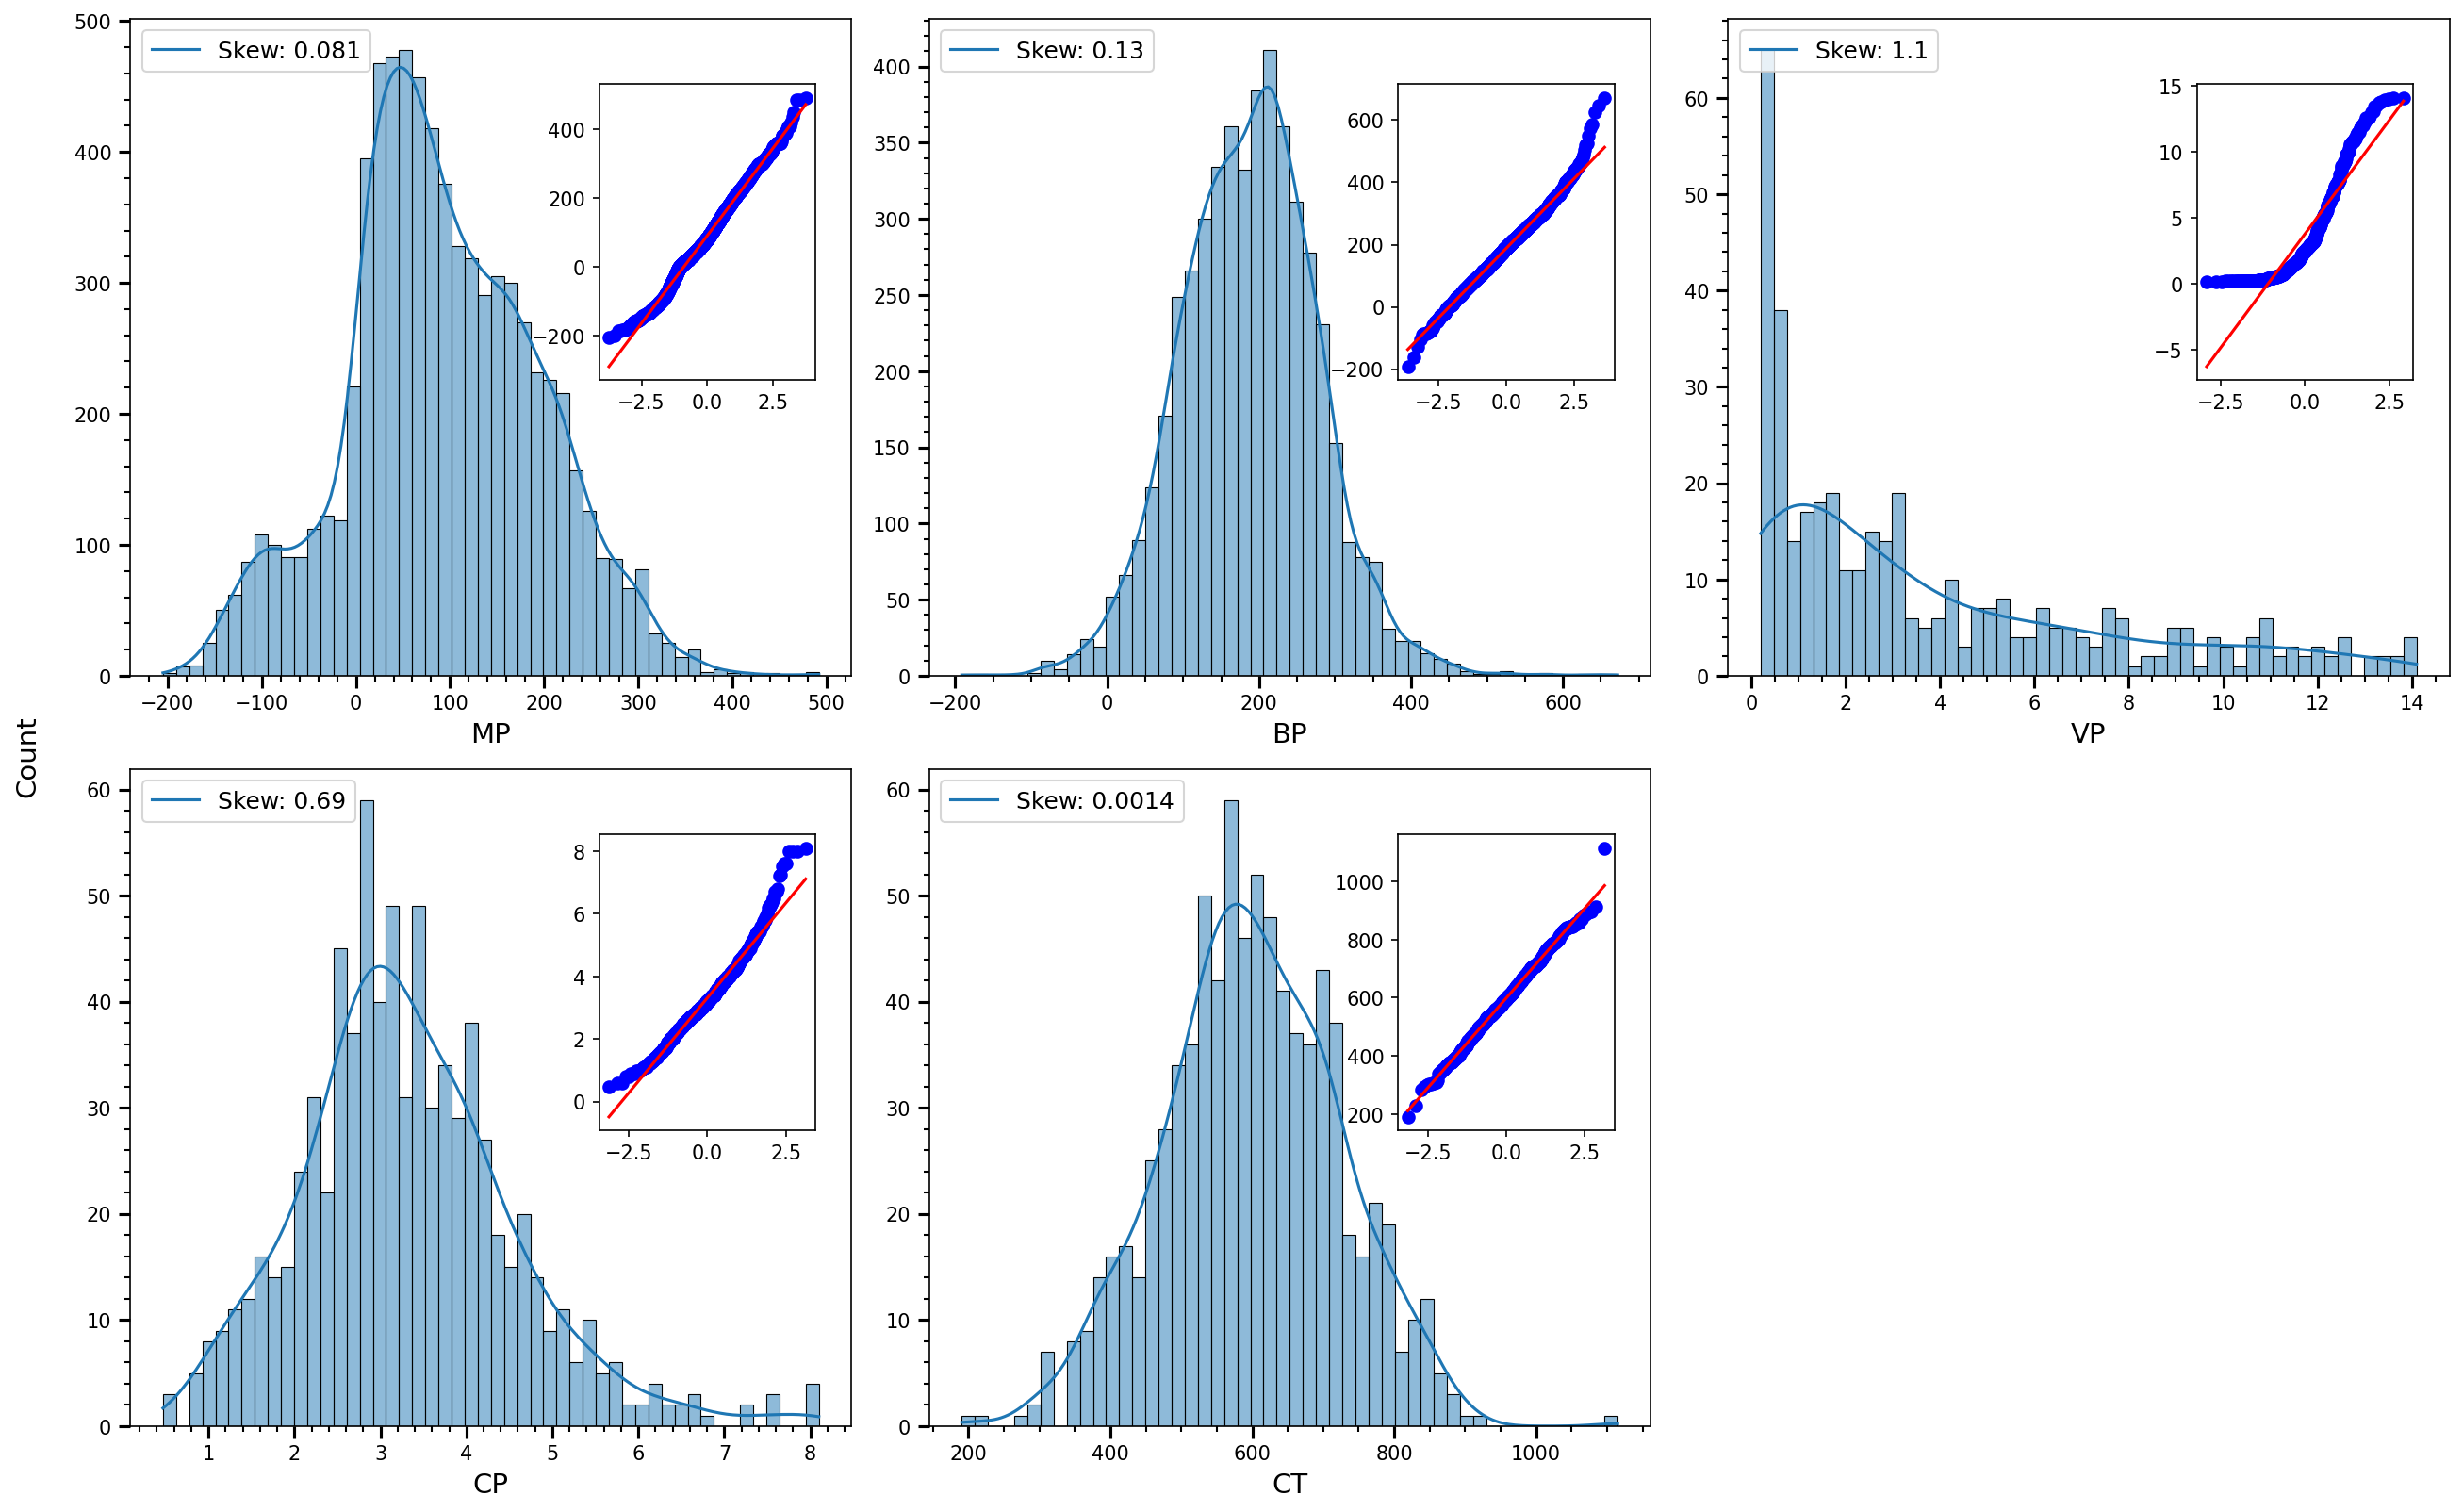

In [119]:
# Create a 3x3 grid of subplots
plt.close('all')
fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=150)

# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()

# Plot the bar plots in the subgrid
for i, data_dir in enumerate(processed_data_dirs):
    if i >= 5:  # Ensure we don't exceed the 2x3 grid
        break
    
    csv_file = data_dir.parent / (data_dir.name.replace('_processed_data', '') + '.csv')
    
    df = pd.read_csv(csv_file)
    y: pd.Series = None
    for col_name in df.columns:
        if col_name.startswith('Processed'):
            y = df[col_name]
            break
    
    if y is None:
        continue
    
    print(data_dir.name, y.shape, csv_file.name)
    ax = axes[i]
    # histplot with KDE
    sns.histplot(y, bins=50, kde=True, ax=ax)  
    ax.set_xlabel(titles[i], fontsize=14)
    ax.set_ylabel('')
    # ax.set_title(titles[i], fontsize=14)
    ax.minorticks_on()
    
    # set skewness and kurtosis as legend
    skewness = y.skew()
    ax.legend([f'Skew: {sigfig.round(skewness, 2)}'], loc='upper left', fontsize=12)
    
    inset_ax = ax.inset_axes([0.65, 0.45, 0.3, 0.45])
    stats.probplot(y, dist="norm", plot=inset_ax)
    inset_ax.set_xlabel('')
    inset_ax.set_ylabel('')
    inset_ax.set_title('')
    # inset_ax.set_title('Q-Q Plot')
    
    ax.tick_params(width=1.5, length=6, which='major')
    ax.tick_params(width=1, length=3, which='minor')
    
# Remove the last subplot (bottom-right) if it exists
if len(processed_data_dirs) < 6:
    fig.delaxes(axes[-1])

# Add common X and Y labels
# fig.text(0.5, 0.04, 'Elemental Distribution', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=14)

# Adjust layout to ensure plots fit well
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
fig.savefig(plots_dir / 'y_distribution.pdf', dpi=150, bbox_inches='tight')
plt.show()

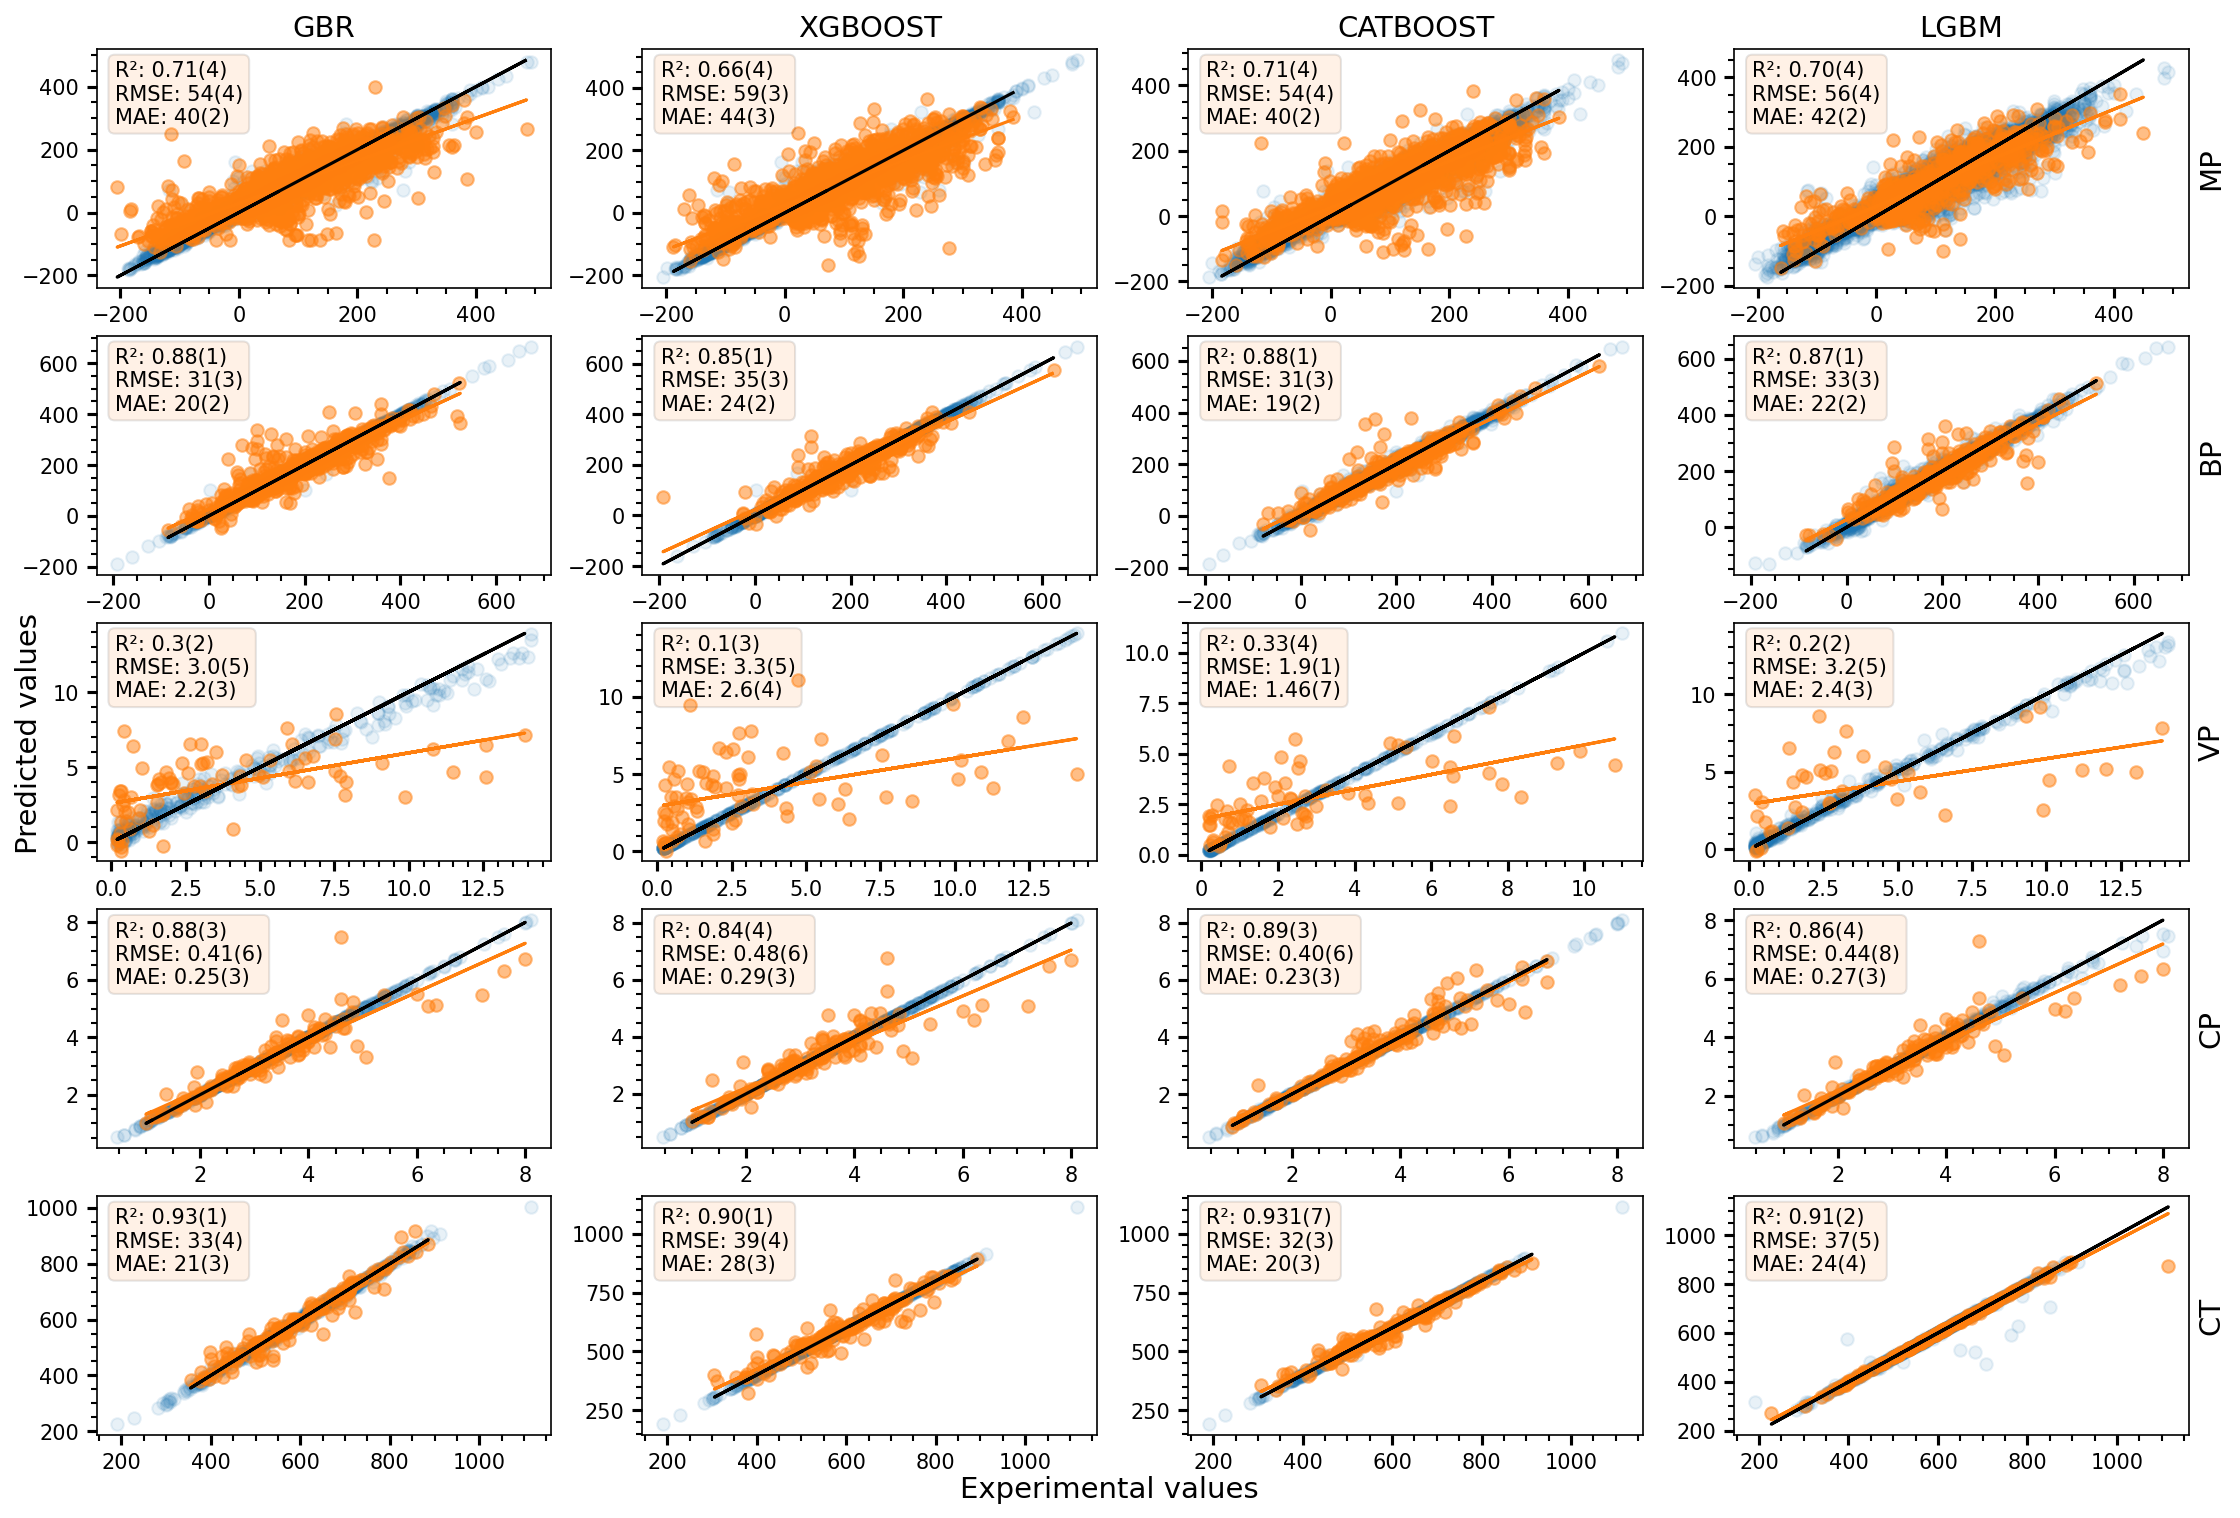

<Figure size 640x480 with 0 Axes>

In [3]:
plt.close('all')
fig, axes = plt.subplots(5, 4, figsize=(18, 12), dpi=150)
# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()
# ind = 0
# dir = processed_data_dirs[ind]

models = ['gbr', 'xgboost', 'catboost', 'lgbm']
for ind, dir in enumerate(processed_data_dirs):
    for i, model in enumerate(models):
        ax = axes[ind * 4 + i]
        embeddings = 'mol2vec_embeddings'
        method = 'default'
        # method = 'best_model'
        if model == 'gbr':
            method = 'best_model'
        pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
        loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'

        # print(dir.name, model, embeddings, method)
        
        resultsfile = loc / f'{pre_trained_filename}.results.json'
        datfile = loc / f'{pre_trained_filename}.dat.json'

        if not resultsfile.exists() or not datfile.exists():
            continue
        
        results = json.load(open(resultsfile, 'r'))
        data = json.load(open(datfile, 'r'))

        y_true_test = data["test"]["y_true"]
        y_pred_test = data["test"]["y_pred"]
        y_linear_fit_test = data["test"]["y_linear_fit"]
        y_linear_fit_train = data["train"]["y_linear_fit"]
        
        y_true_train = data["train"]["y_true"]
        y_pred_train = data["train"]["y_pred"]

        metrics = ["r2", "rmse", "mae"]
        test_scores = {}
        train_scores = {}

        for v in ["test", "train"]:
            for k in metrics:
                mean = results["cv_scores"][v][k]["mean"]
                std = results["cv_scores"][v][k]["std"]
                if v == "test":
                    test_scores[k] = sigfig.round(mean, std, sep="external_brackets")
                else:
                    train_scores[k] = sigfig.round(mean, std, sep="external_brackets")

        ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
        ax.scatter(y_true_test, y_pred_test, color="C1", label="Test", alpha=0.5)
        ax.plot(y_true_test, y_linear_fit_test, color="C1", linewidth=1.5)
        
        # plot an ideal line
        ax.plot(y_true_test, y_true_test, color="k")
        
        if i == len(models) - 1:
            ax.set_ylabel(titles[ind], fontsize=14)
            # set y-label on right side
            ax.yaxis.set_label_position("right")
        if ind == 0:
            ax.set_title(model.upper(), fontsize=14)
            
        
        textstr_test = "\n".join(
            (
                # f"Test ({results['cv_fold']}-fold CV):",
                f'R²: {test_scores["r2"]}',
                f'RMSE: {test_scores["rmse"]}',
                f'MAE: {test_scores["mae"]}',
            )
        )

        ax.text(
            0.04,
            0.95,
            textstr_test,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="C1", alpha=0.1),
        )
        
        ax.minorticks_on()
        ax.tick_params(width=1.5, length=5, which='major')
        ax.tick_params(width=1, length=3, which='minor')
            
fig.text(0.5, 0.08, 'Experimental values', ha='center', va='center', fontsize=14)
fig.text(0.1, 0.5, 'Predicted values', ha='center', va='center', rotation='vertical', fontsize=14)
fig.savefig(plots_dir / 'model_predictions.pdf', dpi=150, bbox_inches='tight')
plt.show()
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

In [190]:
axes

array([<Axes: title={'center': 'GBR'}, xlabel='True values', ylabel='Predicted values'>,
       <Axes: title={'center': 'XGBOOST'}, xlabel='True values', ylabel='Predicted values'>,
       <Axes: title={'center': 'CATBOOST'}, xlabel='True values', ylabel='Predicted values'>,
       <Axes: title={'center': 'LGBM'}, xlabel='True values', ylabel='Predicted values'>,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

tmpC_topelements_processed_data gbr mol2vec_embeddings best_model
tmpC_topelements_processed_data xgboost mol2vec_embeddings default
tmpC_topelements_processed_data catboost mol2vec_embeddings default
tmpC_topelements_processed_data lgbm mol2vec_embeddings default


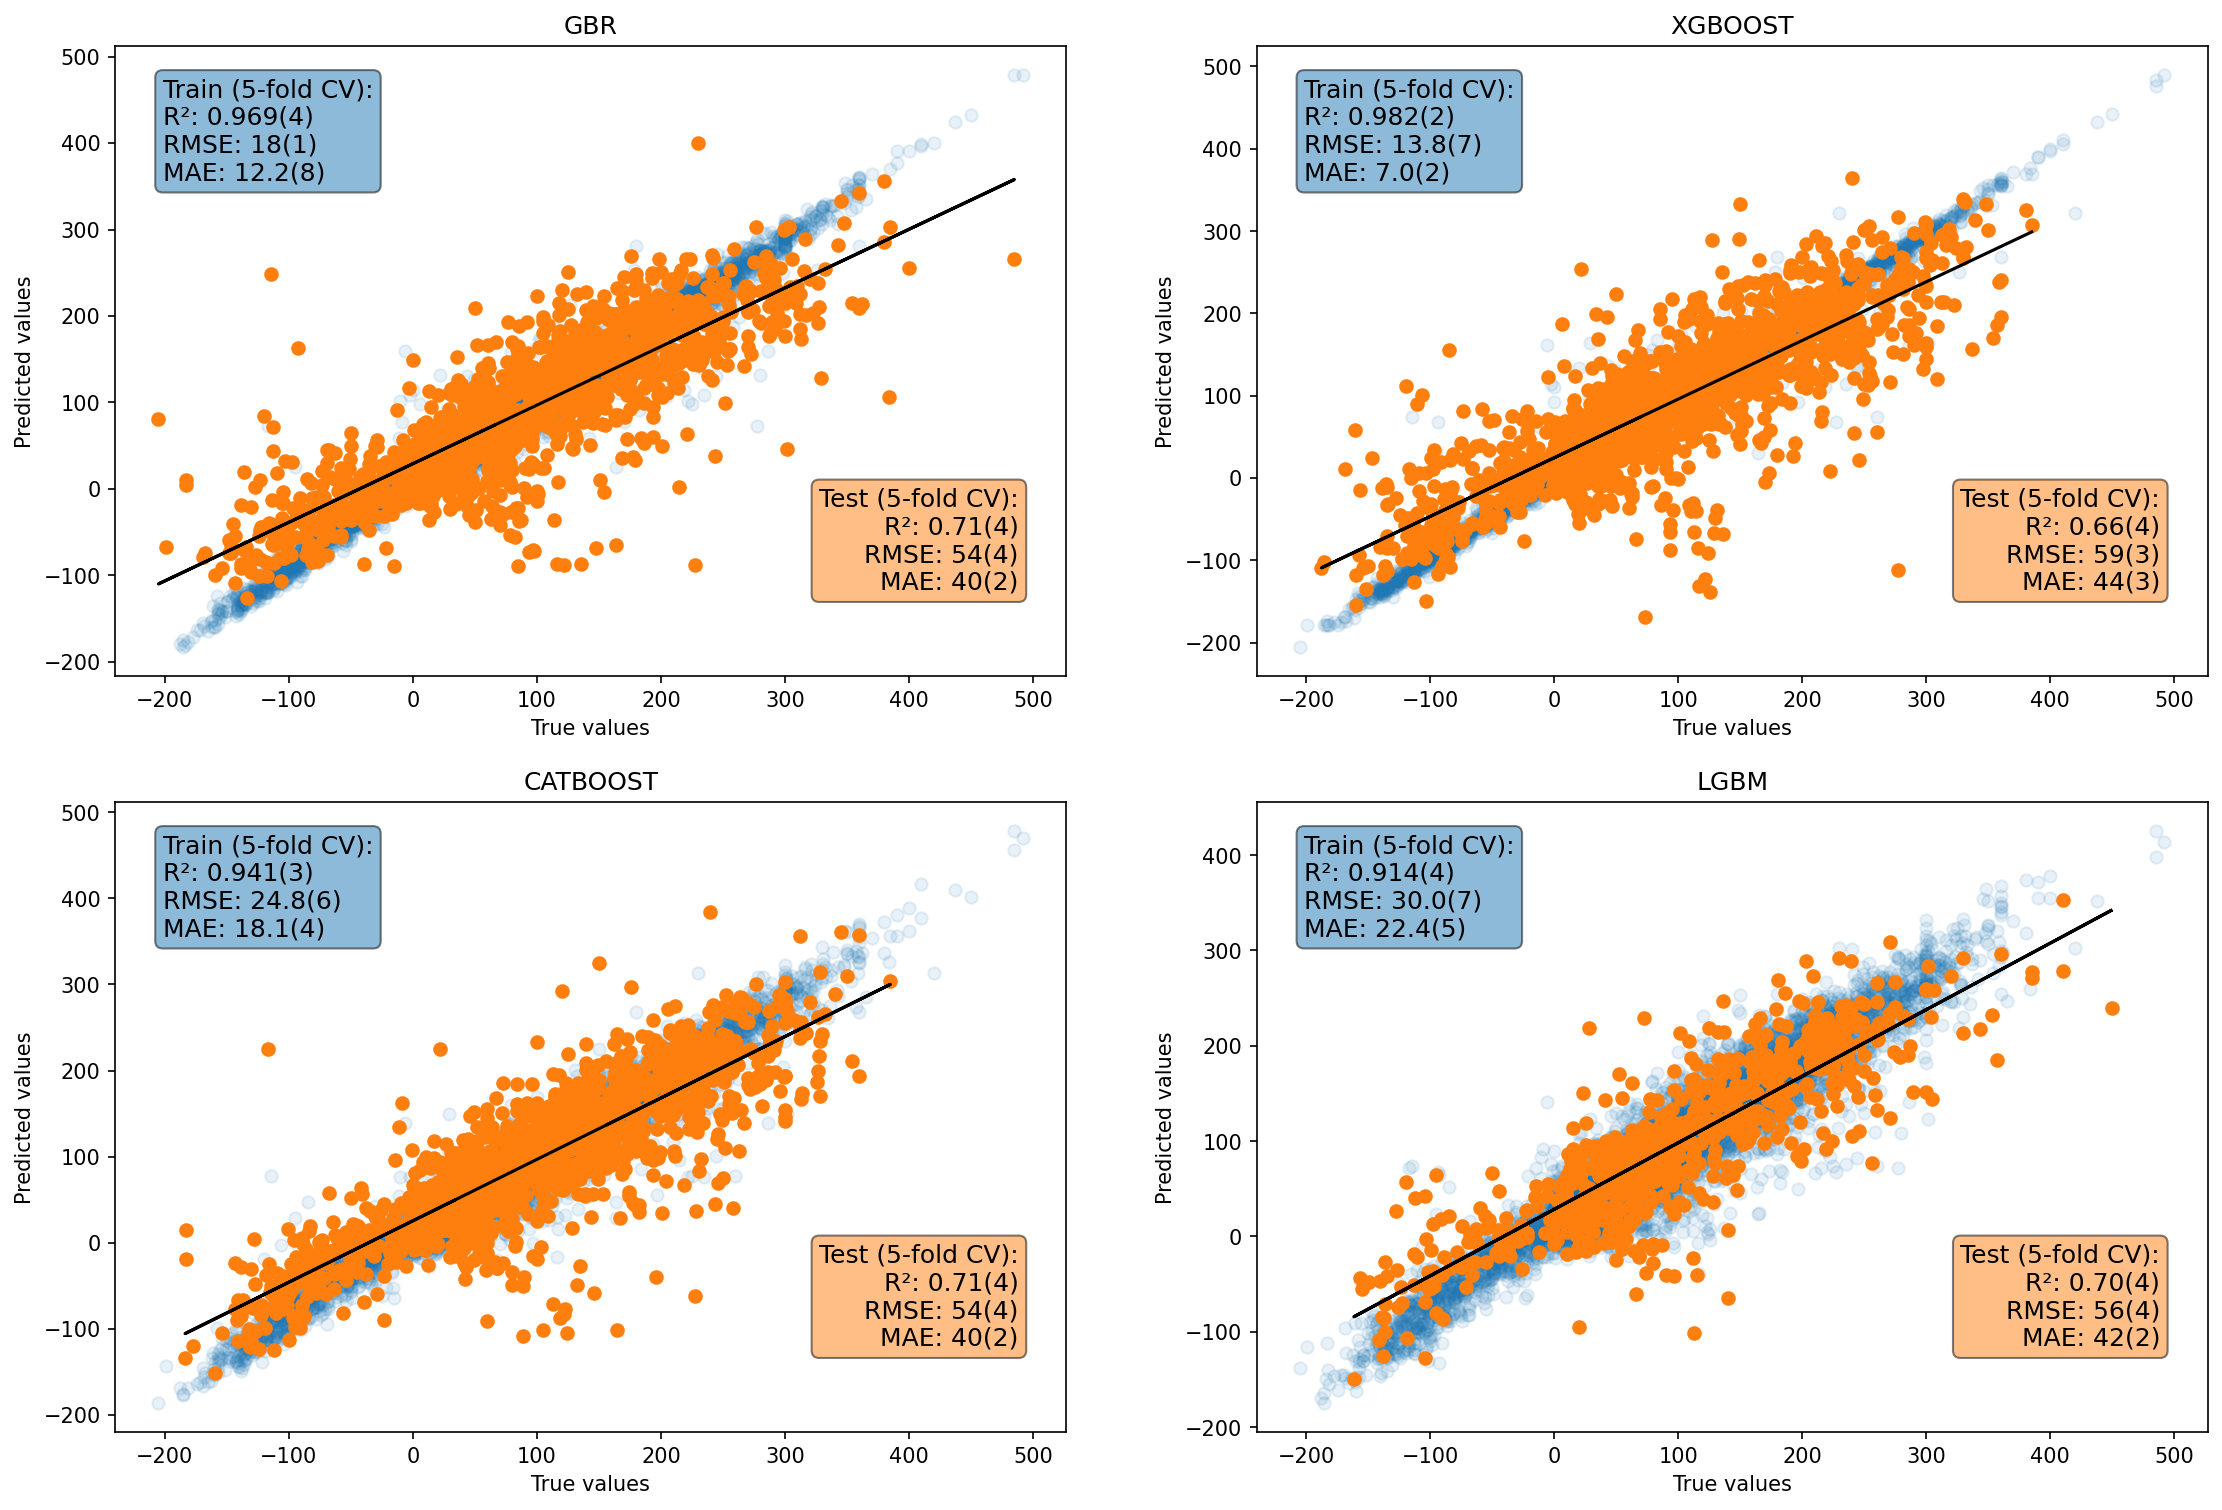

In [ ]:
plt.close('all')
fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=150)
# Flatten the axes array for easy iteration
axes: tuple[plt.Axes] = axes.flatten()
ind = 0
dir = processed_data_dirs[ind]

for i, model in enumerate(['gbr', 'xgboost', 'catboost', 'lgbm']):
    ax = axes[i]
    
    # model = 'lgbm'
    embeddings = 'mol2vec_embeddings'
    method = 'default'
    # method = 'best_model'
    if model == 'gbr':
        method = 'best_model'
    pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
    loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'

    print(dir.name, model, embeddings, method)
    
    resultsfile = loc / f'{pre_trained_filename}.results.json'
    datfile = loc / f'{pre_trained_filename}.dat.json'

    if not resultsfile.exists() or not datfile.exists():
        continue
    
    results = json.load(open(resultsfile, 'r'))
    data = json.load(open(datfile, 'r'))

    y_true_test = data["test"]["y_true"]
    y_pred_test = data["test"]["y_pred"]
    y_linear_fit_test = data["test"]["y_linear_fit"]

    y_true_train = data["train"]["y_true"]
    y_pred_train = data["train"]["y_pred"]
    # y_linear_fit_train = data["train"]["y_linear_fit"]

    metrics = ["r2", "rmse", "mae"]
    test_scores = {}
    train_scores = {}

    for v in ["test", "train"]:
        for k in metrics:
            mean = results["cv_scores"][v][k]["mean"]
            std = results["cv_scores"][v][k]["std"]
            if v == "test":
                test_scores[k] = sigfig.round(mean, std, sep="external_brackets")
            else:
                train_scores[k] = sigfig.round(mean, std, sep="external_brackets")

    ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
    ax.scatter(y_true_test, y_pred_test, color="C1", label="Test")
    ax.plot(y_true_test, y_linear_fit_test, color="k")
    ax.set_xlabel("True values")
    ax.set_ylabel("Predicted values")

    # Add text annotations for metrics
    textstr_train = "\n".join(
        (
            f"Train ({results['cv_fold']}-fold CV):",
            f'R²: {train_scores["r2"]}',
            f'RMSE: {train_scores["rmse"]}',
            f'MAE: {train_scores["mae"]}',
        )
    )

    textstr_test = "\n".join(
        (
            f"Test ({results['cv_fold']}-fold CV):",
            f'R²: {test_scores["r2"]}',
            f'RMSE: {test_scores["rmse"]}',
            f'MAE: {test_scores["mae"]}',
        )
    )

    ax.text(
        0.05,
        0.95,
        textstr_train,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="C0", alpha=0.5),
    )
    ax.text(
        0.95,
        0.30,
        textstr_test,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="C1", alpha=0.5),
    )
    # ax.legend()
    ax.set_title(model.upper())
    # ax.legend([f'{embeddings} ({method})'], fontsize=12)

# print(dir.name)
# fig.savefig(plots_dir / f'{dir.name}_model_predictions.pdf', dpi=150, bbox_inches='tight')
plt.show()

tbp_topelements_processed_data


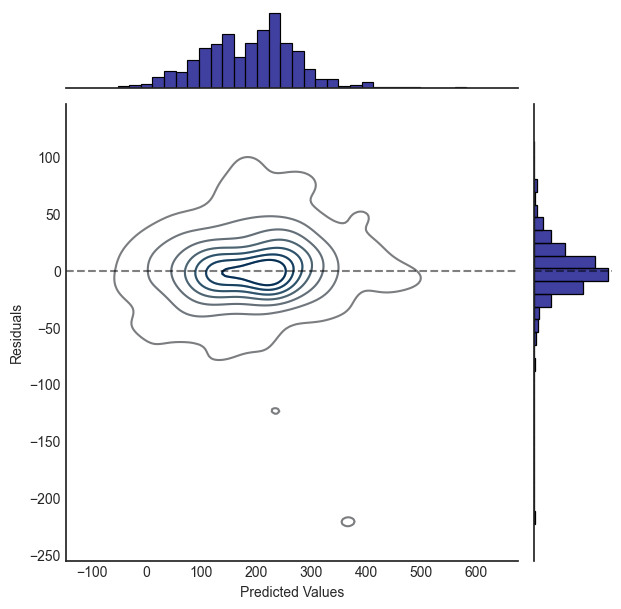

In [ ]:
# Create the joint plot
def create_residual_joint_plot(y_true, y_pred):
    # Calculate residuals
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)

    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    
    # residuals = actual - predicted
    residuals = y_true - y_pred
    
    # A central scatter plot with contour lines showing residuals vs. predicted values
    # A histogram on top showing the distribution of predicted values
    # A histogram on the right showing the distribution of residuals
    
    # Create joint plot
    g = sns.JointGrid(x=y_pred, y=residuals)
    # g = sns.JointGrid(x=y_true, y=residuals)
    
    # Add contour plot in the center
    g.plot_joint(sns.kdeplot, cmap='Blues', levels=8)
    
    # Add histograms on the margins
    g.plot_marginals(sns.histplot, color='navy', bins=30)
    
    # Add reference line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Customize labels and title
    g.ax_joint.set_xlabel("Predicted Values")
    g.ax_joint.set_ylabel("Residuals")
    
    # Add contour lines
    sns.kdeplot(x=y_pred, y=residuals, ax=g.ax_joint, 
                levels=8, color='black', alpha=0.5)
    
    # Add y=0 horizontal line
    g.ax_joint.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    return g

ind = 1
dir = processed_data_dirs[ind]
print(dir.name)
model = 'catboost'
embeddings = 'mol2vec_embeddings'
method = 'default'
# method = 'best_model'
if model == 'gbr':
    method = 'best_model'
pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
loc = dir / f'pretrained_models/{model}/{embeddings}/{method}/'
datfile = loc / f'{pre_trained_filename}.dat.json'

data = json.load(open(datfile, 'r'))
y_true_test = data["test"]["y_true"]
y_pred_test = data["test"]["y_pred"]
y_linear_fit_test = data["test"]["y_linear_fit"]

create_residual_joint_plot(y_true_test, y_pred_test)

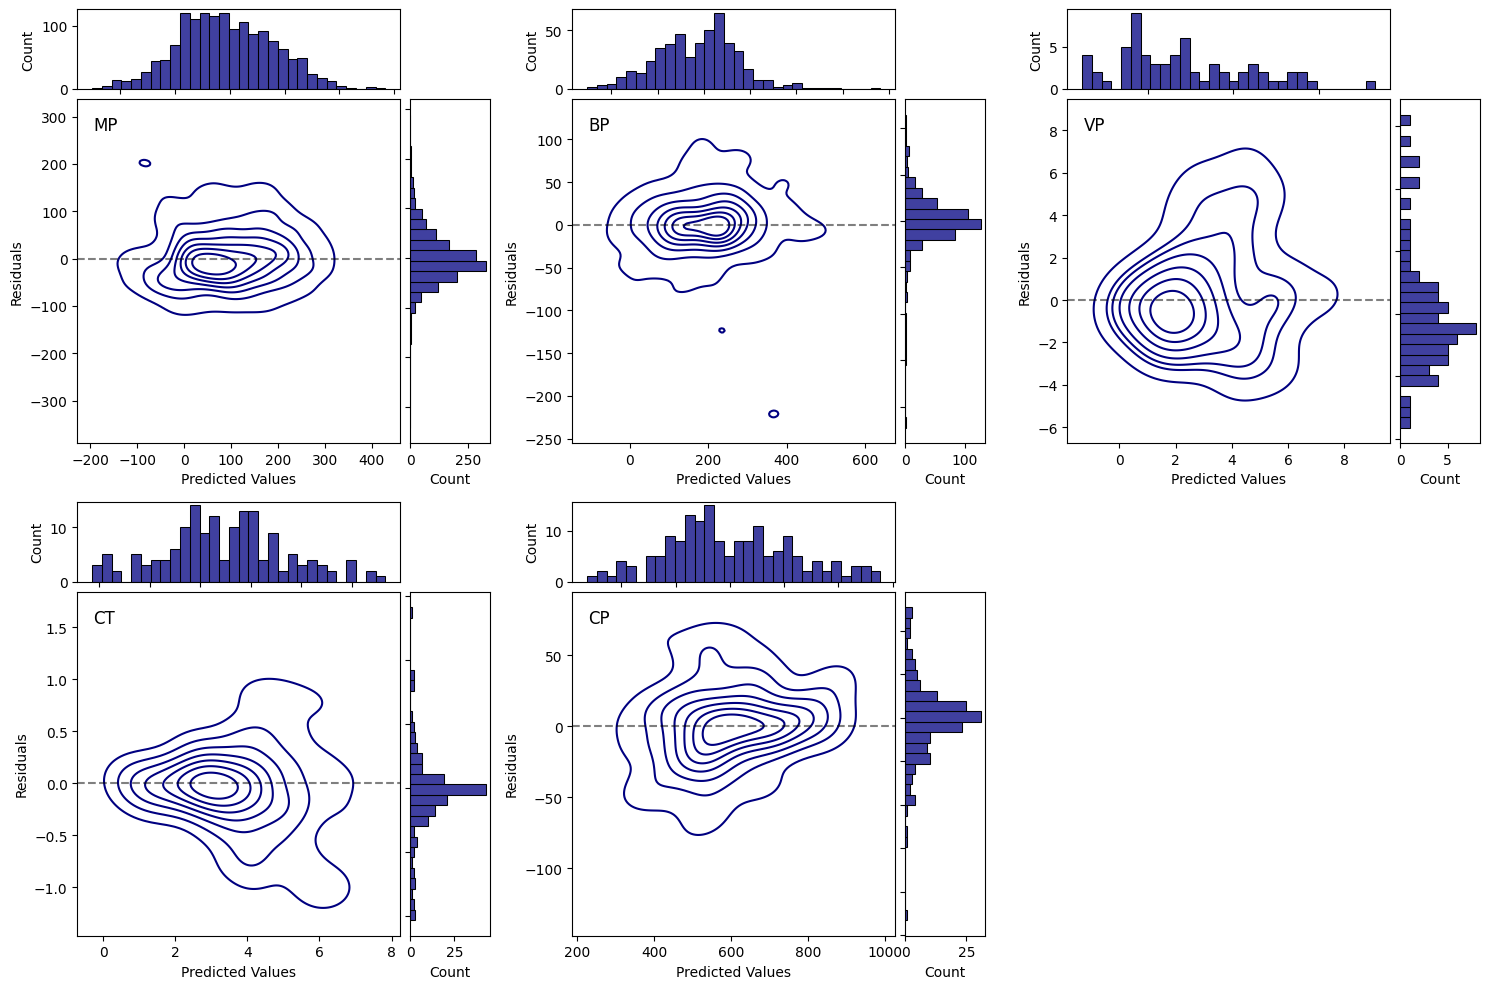

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

def create_residual_subplot(y_true: np.ndarray, y_pred: np.ndarray, ax: plt.Axes, prop: str):
    """Creates a residual plot with density contours on a given matplotlib axis."""
    if not isinstance(y_true, np.ndarray):
        y_true = np.array(y_true)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    
    residuals = y_true - y_pred
    
    # Create scatter plot with density
    sns.kdeplot(x=y_pred, y=residuals, ax=ax, color='navy', levels=8)
    
    # Add histograms on both axes
    divider = make_axes_locatable(ax)
    ax_histx: plt.Axes = divider.append_axes("top", 0.8, pad=0.1)
    ax_histy: plt.Axes = divider.append_axes("right", 0.8, pad=0.1)
    
    # Plot histograms
    sns.histplot(x=y_pred, ax=ax_histx, color='navy', bins=30)
    sns.histplot(y=residuals, ax=ax_histy, color='navy', bins=30, orientation='horizontal')
    
    # Remove histogram axis labels
    ax_histx.set_xticklabels([])
    ax_histy.set_yticklabels([])
    
    # Add reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Customize labels
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")
    ax.text(0.05, 0.95, prop, transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Create figure with subplots
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

# Define titles and positions
properties = ['MP', 'BP', 'VP', 'CT', 'CP']
positions = [gs[0, 0], gs[0, 1], gs[0, 2], gs[1, 0], gs[1, 1]]

counter = 0
for prop, pos in zip(properties, positions):
    ax = fig.add_subplot(pos)
    model = 'catboost'
    embeddings = 'mol2vec_embeddings'
    method = 'default'
    pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
    
    # Load data for each property
    dir = processed_data_dirs[properties.index(prop)]
    datfile = dir / f'pretrained_models/{model}/{embeddings}/{method}/{pre_trained_filename}.dat.json'
    data = json.load(open(datfile, 'r'))
    y_true_test = data["test"]["y_true"]
    y_pred_test = data["test"]["y_pred"]
    
    create_residual_subplot(y_true_test, y_pred_test, ax, prop)

    # ax.set_title(f"{prop} Residuals")
    counter += 1
    
plt.tight_layout()
fig.savefig(plots_dir / f'{pre_trained_filename}_residual_plot.pdf', dpi=150, bbox_inches='tight')
plt.show()

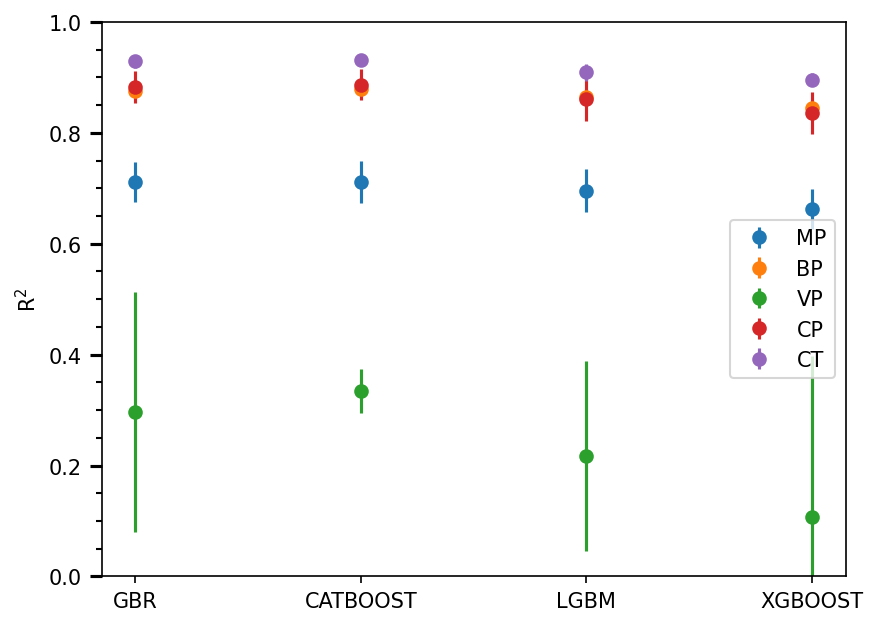

In [6]:
plt.close('all')
fig, ax = plt.subplots(dpi=150)
# models = ['gbr', 'xgboost', 'catboost', 'lgbm']
models = ['gbr', 'catboost', 'lgbm', 'xgboost']
x_models = [x.upper() for x in models]


r2_metrics = {}

for i, data_dir in enumerate(processed_data_dirs):
    color = f'C{i}'
    r2_metrics[data_dir.name] = {}
    for embeddings in ['mol2vec_embeddings', 'VICGAE_embeddings']:
        r2_metrics[data_dir.name][embeddings] = {}
        
        y_r2 = []
        y_err_r2 = []
        
        for model in models:
            method = 'default'
            if model == 'gbr':
                method = 'best_model'
                
            r2_metrics[data_dir.name][embeddings][model] = {}
                
            pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
            loc = data_dir / f'pretrained_models/{model}/{embeddings}/{method}/'
            
            # print(data_dir.name, model, embeddings, method)
            name = data_dir.name.replace('_processed_data', '')
            name = name.replace('_topelements', '')
            
            resultsfile = loc / f'{pre_trained_filename}.results.json'
            datfile = loc / f'{pre_trained_filename}.dat.json'

            if not resultsfile.exists() or not datfile.exists():
                continue
            
            results = json.load(open(resultsfile, 'r'))
            metric = 'r2'
            
            r2_mean = float(results["cv_scores"]['test'][metric]["mean"])
            r2_std = float(results["cv_scores"]['test'][metric]["std"])
            
            y_r2.append(r2_mean)
            y_err_r2.append(r2_std)
            
            r2_metrics[data_dir.name][embeddings][model]['test'] = {
                'mean': r2_mean,
                'std': r2_std
            }
            r2_metrics[data_dir.name][embeddings][model]['train'] = {
                'mean': float(results["cv_scores"]['train'][metric]["mean"]),
                'std': float(results["cv_scores"]['train'][metric]["std"])
            }

        
        fmt = 'o'
        if embeddings == 'VICGAE_embeddings':
            fmt = 's'
            continue
        
        ax.errorbar(
            x_models, 
            y_r2, 
            yerr=y_err_r2, 
            fmt=fmt,
            c=color, 
            label=f'{titles[i]}'
        )
        
ax.legend()
# ax.minorticks_on()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel('R$^2$')
ax.set_ybound(0.0, 1.0)
ax.tick_params(axis='y', width=1.5, length=6, which='major')
ax.tick_params(axis='y', width=1, length=3, which='minor')
# fig.savefig(plots_dir / 'r2_scores.pdf', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
models, r2_metrics['tmpC_topelements_processed_data']['mol2vec_embeddings']

def get_scores_for_all_models(
    name = 'tmpC_topelements_processed_data', embeddings = 'mol2vec_embeddings', data_type = 'test'
):
    scores = []
    errors = []
    # print(name, embeddings, data_type)
    for model in models:
        scores.append(r2_metrics[name][embeddings][model][data_type]['mean'])
        errors.append(r2_metrics[name][embeddings][model][data_type]['std'])
        
    return scores, errors

# get_scores_for_all_models()


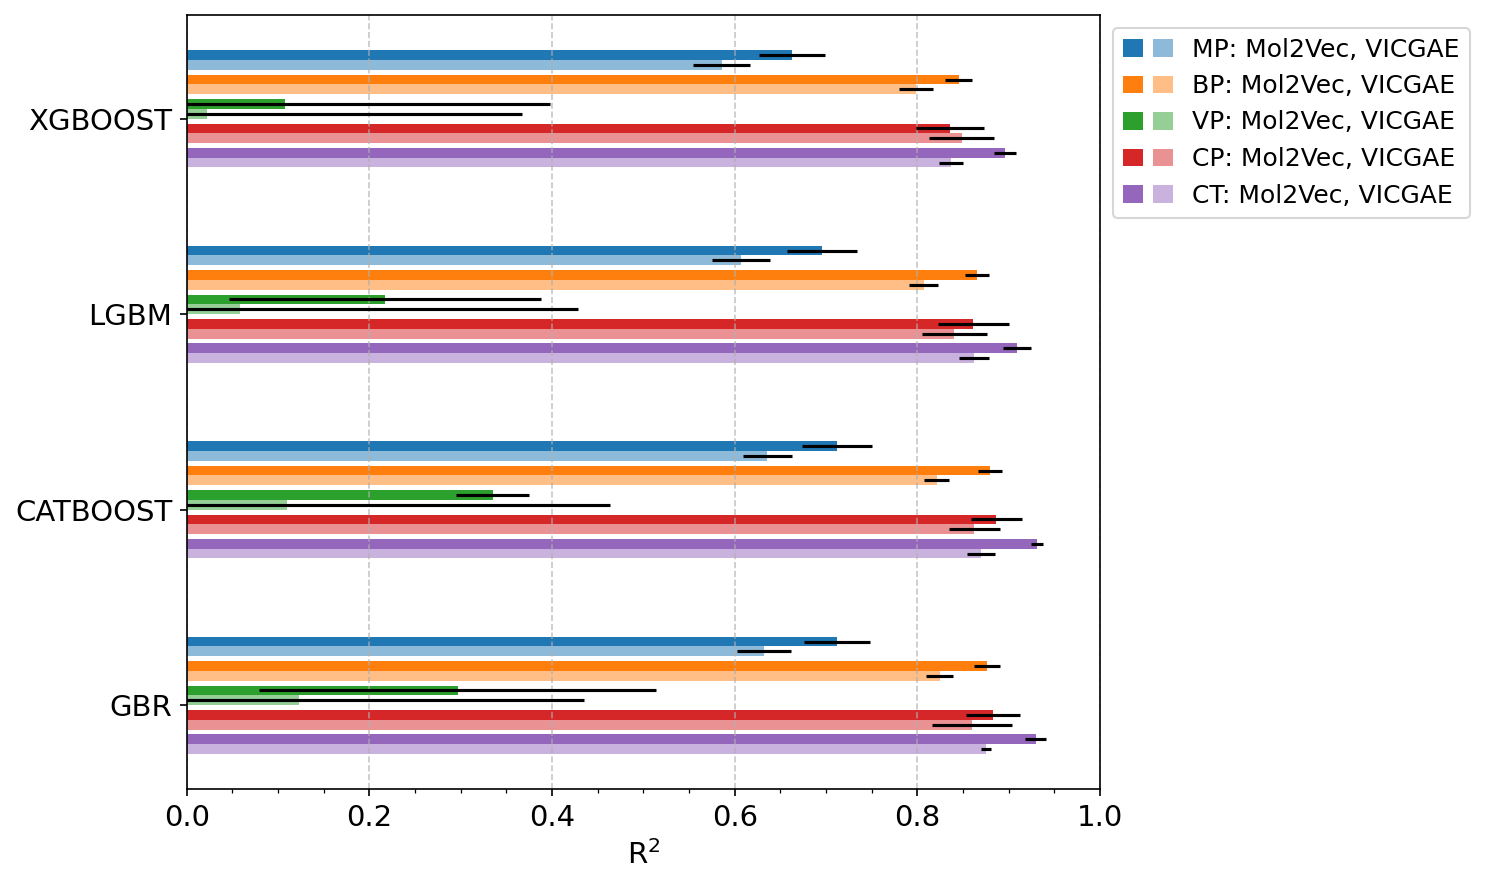

In [8]:
from matplotlib.legend_handler import HandlerTuple
plt.close('all')

data_names = [d.name for d in processed_data_dirs]

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

bar_width = 0.1
gap_width = 0.05  # Gap between Mol2Vec/VICGAE pairs
model_gap = 1   # Add gap between different models

# index = np.arange(len(models))
index = np.arange(len(models)) * (1 + model_gap)  # Multiply by (1 + model_gap) to space out models

n_datasets = len(data_names)
# total_width = bar_width * (n_datasets * 2)
total_width = bar_width * (n_datasets * 2) + gap_width * (n_datasets - 1)  # Adjust total width to account for gaps

# name = data_names[0]
# Dictionary to store handles for legend
legend_handles = []
titles = ['MP', 'BP', 'VP', 'CP', 'CT']

for i, (name, title) in enumerate(zip(data_names, titles)):
    mol2vec_scores, mol2vec_errors = get_scores_for_all_models(name, embeddings='mol2vec_embeddings')
    vicgae_scores, vicgae_errors = get_scores_for_all_models(name, embeddings='VICGAE_embeddings')
    
    # offset = i * bar_width * 2 - total_width/2 + bar_width/2
    # Modify offset calculation to include gaps
    offset = i * (bar_width * 2 + gap_width) - total_width/2 + bar_width/2
    
    color = f'C{i}'
    
    h1 = ax.barh(index - offset + bar_width, mol2vec_scores, bar_width, xerr=mol2vec_errors, 
            color=color, alpha=1)
    h2 = ax.barh(index - offset, vicgae_scores, bar_width, xerr=vicgae_errors,
            color=color, alpha=0.5)

    # Add both handles with custom labels
    legend_handles.extend([(h1, h2, f'{title}: Mol2Vec, VICGAE')])
    
# Adding labels
ax.set_xlabel('R$^2$', fontsize=14)
# ax.set_ylabel('Models')
ax.set_yticks(index)
ax.set_yticklabels(x_models, fontsize=14)
ax.set_xlim(0, 1.0)

# increase x-tick label font size
ax.tick_params(axis='x', labelsize=14)

# place the legend outside the plot
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncols=2)

# Create custom legend with combined labels
flat_handles = [(h[0], h[1]) for h in legend_handles]
labels = [h[2] for h in legend_handles]
ax.legend(flat_handles, labels, loc='upper left', bbox_to_anchor=(1, 1), 
         handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=12)

ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Show plot
plt.tight_layout()
fig.savefig(plots_dir / 'r2_scores_bar.pdf', dpi=150, bbox_inches='tight')
plt.show()


In [181]:
num = 5
index, bar_width, index + bar_width / num, index - bar_width / num

(array([0, 2, 4, 6]),
 0.35,
 array([0.07, 2.07, 4.07, 6.07]),
 array([-0.07,  1.93,  3.93,  5.93]))

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Sample molecules with their descriptions
sample_molecules = {
    'aspirin': 'CC(=O)OC1=CC=CC=C1C(=O)O',  # Contains aromatic ring, ester, carboxylic acid
    'caffeine': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',  # Contains imidazole ring, amides
    'testosterone': 'CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C',  # Complex ring system with ketone
    'benzene': 'C1=CC=CC=C1',  # Simple aromatic ring
    'glucose': 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O',  # Multiple alcohols, cyclic ether
    'alanine': 'CC(C(=O)O)N',  # Amino acid: amine and carboxylic acid
    'ethanol': 'CCO',  # Simple alcohol
    'acetone': 'CC(=O)C',  # Simple ketone
    'morphine': 'CN1CC[C@]23[C@H]4C1=C[C@@H]([C@H]2O)C=C[C@H]3O4',  # Complex natural product
    'ibuprofen': 'CC(C)CC1=CC=C(C=C1)[C@H](C)C(=O)O'  # Aromatic ring, carboxylic acid
}

def identify_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    functional_groups = {
        'alcohol': '[OH]',
        'carboxylic_acid': '[C](=O)[OH]',
        'amine': '[NH2]',
        'aldehyde': '[CH]=O',
        'ketone': '[C](=O)[C]',
        'ether': '[O;R0]([C])[C]',
        'ester': '[C](=O)[O][C]',
        'amide': '[C](=O)[N]',
        'phenol': '[OH]c1ccccc1',
        'alkene': '[C]=[C]',
        'alkyne': '[C]#[C]'
    }
    
    results = {}
    for name, smarts in functional_groups.items():
        pattern = Chem.MolFromSmarts(smarts)
        matches = mol.GetSubstructMatches(pattern)
        results[name] = len(matches)
    return results

def analyze_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return {
        'total_rings': rdMolDescriptors.CalcNumRings(mol),
        'aromatic_rings': rdMolDescriptors.CalcNumAromaticRings(mol),
        'aliphatic_rings': rdMolDescriptors.CalcNumAliphaticRings(mol),
        'saturated_rings': rdMolDescriptors.CalcNumSaturatedRings(mol),
        'heterocycles': rdMolDescriptors.CalcNumHeterocycles(mol)
    }

# Test the functions
for name, smiles in sample_molecules.items():
    print(f"\nAnalyzing {name.upper()} ({smiles})")
    print("\nFunctional Groups:")
    fg_results = identify_functional_groups(smiles)
    for group, count in fg_results.items():
        if count > 0:
            print(f"{group}: {count}")
            
    print("\nRing Analysis:")
    ring_results = analyze_rings(smiles)
    for ring_type, count in ring_results.items():
        print(f"{ring_type}: {count}")
    print("-" * 50)

In [ ]:
# Sample molecules with their descriptions
glucose_smi = 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O'
glucose_smarts = 'C([C@@H]1[C@H]([C@@H]([C@H](C(O1)O)O)O)O)O'

In [ ]:
Chem.MolFromSmiles('CN1CC[C@]23[C@H]4C1=C[C@@H]([C@H]2O)C=C[C@H]3O4')
# Chem.MolFromSmarts('[O;R0]([C])[C]')